<a href="https://colab.research.google.com/github/tomaszpionka/ds-project/blob/main/wum4zaoczne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sieci konwolucyjne (CNN)

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn

# transform - tworzymy przekształcenie obrazu na pytorchowy tensor, oraz normalizujemy
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        # transforms.RandomResizedCrop(28),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ])

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]) #normalizowanie - średnia i wariancja. liczby podane od pytorch


#ładowanie danch, za pierwszym razem dane zostaną pobrane
train_set = torchvision.datasets.MNIST('./data/mnist', train=True, download=True, 
                  transform=data_transform)
test_set = torchvision.datasets.MNIST('./data/mnist', train=False, download=True, 
                  transform=transform)

train_set=torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_set=torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)

len(train_set)


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Processing...
Done!


600

In [ ]:
for t in train_set:
  print(t[0].shape)
  break

torch.Size([100, 1, 28, 28])


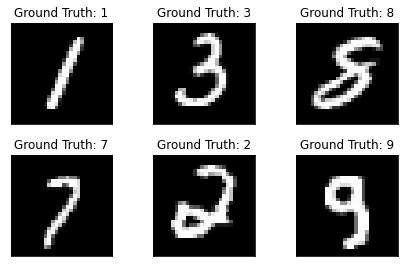

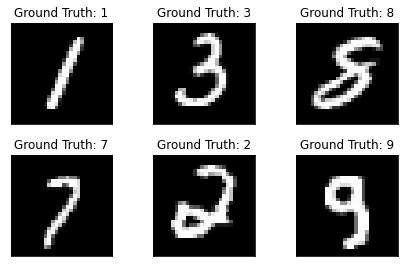

In [ ]:
import matplotlib.pyplot as plt

train = enumerate(train_set)

index, (example_data, example_targets)= next(train)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2) #inchannels =1 dlatego, że obraz jest czarnobialy
        # self.norm=nn.BatchNorm2d(32)

        self.relu=nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)#kernel_size,stride

        self.conv2=nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.relu2=nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)


    def forward(self, x):
        # print(x.shape) #--> [100, 1, 28, 28]
        out = self.conv1(x)
        # print(out.shape) #--> [100, 32, 28, 28]
        # out=self.norm(out)
        out=self.relu(out)
        # print(out.shape) #--> [100, 32, 28, 28]
        out=self.pool(out)
        # print(out.shape) #--> [100, 32, 14, 14]
        # print("conv2")
        out = self.conv2(out)
        # print(out.shape) #--> [100, 64, 14, 14]
        out=self.relu2(out)
        # print(out.shape) #--> [100, 64, 14, 14]
        out=self.pool2(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)# przed przekazaniem dalej do wartswty liniowej, sprowadzamy do jednego wymiaru
        #print(out.shape)
        
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Rozmiar wyjściowy każdej warstwy (conv oraz pooling), może być obliczony za pomocą wzoru:

$W_{out}= \frac{W_{in}-F+2P}{stride} + 1$

W_in-rozmiar wejściowy brazu (nie mylić z input_channels)

F-rozmiar filtru (kernel size)

P-rozmiar "padding"- dodatkowych "pustych" pikseli

stride - liczba pikseli, co ile jest przesuwany filtr

In [ ]:
model = ConvNet().cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

In [ ]:
# Train the model
total_step = len(train_set)
loss_list = []
acc_list = []
num_epochs=5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_set):
        # Run the forward pass
        labels=labels.cuda()
        outputs = model(images.cuda())
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/5], Step [100/600], Loss: 0.6120, Accuracy: 87.00%
Epoch [1/5], Step [200/600], Loss: 0.2766, Accuracy: 97.00%
Epoch [1/5], Step [300/600], Loss: 0.3051, Accuracy: 94.00%
Epoch [1/5], Step [400/600], Loss: 0.2637, Accuracy: 95.00%
Epoch [1/5], Step [500/600], Loss: 0.3748, Accuracy: 87.00%
Epoch [1/5], Step [600/600], Loss: 0.2586, Accuracy: 95.00%
Epoch [2/5], Step [100/600], Loss: 0.2619, Accuracy: 94.00%
Epoch [2/5], Step [200/600], Loss: 0.3559, Accuracy: 92.00%
Epoch [2/5], Step [300/600], Loss: 0.3848, Accuracy: 91.00%
Epoch [2/5], Step [400/600], Loss: 0.2154, Accuracy: 97.00%
Epoch [2/5], Step [500/600], Loss: 0.2865, Accuracy: 92.00%
Epoch [2/5], Step [600/600], Loss: 0.2100, Accuracy: 96.00%
Epoch [3/5], Step [100/600], Loss: 0.2779, Accuracy: 92.00%
Epoch [3/5], Step [200/600], Loss: 0.2464, Accuracy: 95.00%
Epoch [3/5], Step [300/600], Loss: 0.2367, Accuracy: 95.00%
Epoch [3/5], Step [400/600], Loss: 0.2561, Accuracy: 93.00%
Epoch [3/5], Step [500/600], Loss: 0.245

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_set:
        labels=labels.cuda()
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the test images: 95.36 %



## Facial keypoints detection
Utwórz sieć konwolucyjną, która identyfikuje punkty na twarzy.

Dane znajdują się w folderze facialkeypoints. Pierwsze 30 kolumn zawiera współrzędne punktów na twarzy. 31 kolumna zawiera czarnobiałą reprezentację obrazu. Wyświetl w pythonie, kilka przykładowych obrazów(plt.imshow),wraz z punktami(plt.scatter). Rozmiar obrazu to 96 x 96

Przygotuj własną klasę dziedziczącą po Dataset, która pozwoli na wczytanie zbioru danych w odpowiedniej formie. (torch.utils.data.Dataset) Wyczyść dane: usuń te sample gdzie występują wartości puste, sprawdz czy każdy obraz ma podobny rozmiar.

Podziel dane treningowe i testowe i wczytaj je za pomocą dataset
Wykorzystaj DataLoader do iteracji po danych testowych i treningowych. (torch.utils.data.DataLoader)

Zaprojektuj architekturę sieci konwolucyjnej do zadania regresji. Użyj minimum dwóch warstw konwolucyjnych z i conajmniej jednej warstwy liniowej. Użyj odpowiedniej funkcji kosztu- pamietajac ze nie jest to klasyfikacja .

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#

Do tego zadania możesz usunąć przykłady z brakującymi danymi.

In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
from torch import nn, optim
import warnings
warnings.filterwarnings('ignore')

IMG_SIZE = 96

data = pd.read_csv('/content/sample_data/training.csv')
data.dropna(inplace=True) 

Dane znajdują się w folderze facialkeypoints. Pierwsze 30 kolumn zawiera współrzędne punktów na twarzy. 31 kolumna zawiera czarnobiałą reprezentację obrazu. Wyświetl w pythonie, kilka przykładowych obrazów(plt.imshow),wraz z punktami(plt.scatter). Rozmiar obrazu to 96 x 96

In [240]:
def show_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker ='.', c='r')

In [241]:

def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):
    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32).reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32).reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')
        plt.tight_layout()
        show_keypoints(image, keypoints)
    plt.show()

In [242]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712 entries, 0 to 1711
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          1712 non-null   float64
 1   left_eye_center_y          1712 non-null   float64
 2   right_eye_center_x         1712 non-null   float64
 3   right_eye_center_y         1712 non-null   float64
 4   left_eye_inner_corner_x    1712 non-null   float64
 5   left_eye_inner_corner_y    1712 non-null   float64
 6   left_eye_outer_corner_x    1712 non-null   float64
 7   left_eye_outer_corner_y    1712 non-null   float64
 8   right_eye_inner_corner_x   1712 non-null   float64
 9   right_eye_inner_corner_y   1712 non-null   float64
 10  right_eye_outer_corner_x   1712 non-null   float64
 11  right_eye_outer_corner_y   1712 non-null   float64
 12  left_eyebrow_inner_end_x   1712 non-null   float64
 13  left_eyebrow_inner_end_y   1712 non-null   float

In [243]:
test_data = test_data.filter(['Image'])
test_data['ImageId'] = range(1, len(test_data) + 1)
test_data = test_data[['ImageId', 'Image']]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  428 non-null    int64 
 1   Image    428 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.8+ KB


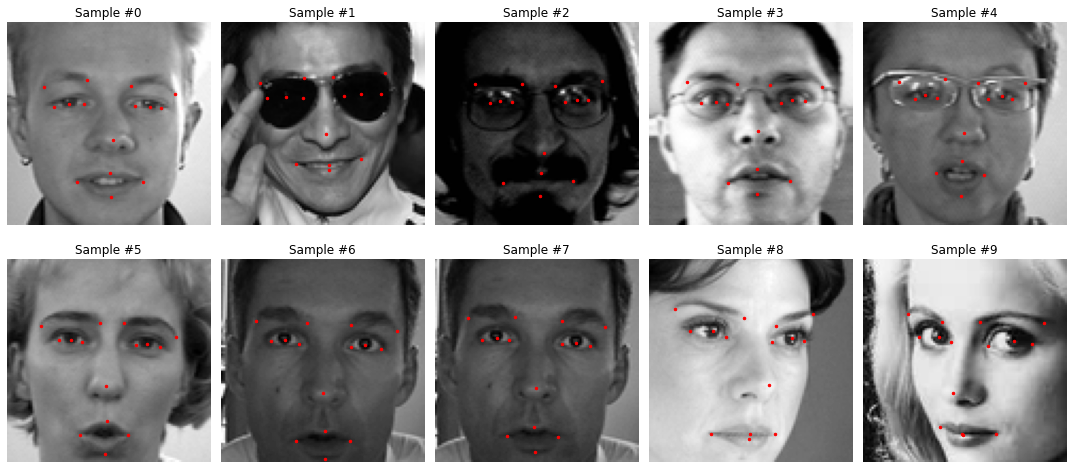

In [244]:
show_images(train_data, range(10))

Przygotuj własną klasę dziedziczącą po Dataset, która pozwoli na wczytanie zbioru danych w odpowiedniej formie. (torch.utils.data.Dataset) Wyczyść dane: usuń te sample gdzie występują wartości puste, sprawdz czy każdy obraz ma podobny rozmiar.

In [245]:
class FaceKeypointsDataset(Dataset):
   
    def __init__(self, dataframe, train=True, transform=None):
        self.dataframe = dataframe
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)       
        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None
        sample = {'image': image, 'keypoints': keypoints}    
        if self.transform:
            sample = self.transform(sample)   
        return sample

In [246]:
class Normalize(object):
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        return {'image': image / 255., # scale to [0, 1]
                'keypoints': keypoints}
        
class ToTensor(object):
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

In [247]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)
    
    return train_loader, valid_loader

In [248]:
train_df = train_data.dropna()
test_df = test_data

batch_size = 128
valid_size = 0.2

tsfm = transforms.Compose([Normalize(), ToTensor()])

trainset = FaceKeypointsDataset(train_df, transform=tsfm)
testset = FaceKeypointsDataset(test_df, train=False, transform=tsfm)

train_loader, valid_loader = prepare_train_valid_loaders(trainset, 
                                                         valid_size,
                                                         batch_size)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [249]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):

    valid_loss_min = np.Inf

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch['image'].to(device))
            loss = criterion(output, batch['keypoints'].to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*batch['image'].size(0)

        model.eval()
        for batch in valid_loader:
            output = model(batch['image'].to(device))
            loss = criterion(output, batch['keypoints'].to(device))
            valid_loss += loss.item()*batch['image'].size(0)

        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses

In [250]:
def plot_RMSE(train_losses, valid_losses, y_max=50):
    plt.plot(train_losses, "--", linewidth=3, label="train")
    plt.plot(valid_losses, linewidth=3, label="val")
    plt.legend()
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.ylim((0, y_max))
    plt.show()

In [251]:
def predict(data_loader, model):
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))
    
    return predictions

In [252]:
def view_pred_df(columns, test_df, predictions, image_ids=range(1,11)):

    pred_df = pd.DataFrame(predictions, columns=columns)
    pred_df = pd.concat([pred_df, test_df], axis=1)
    pred_df = pred_df.set_index('ImageId')
    show_images(pred_df, image_ids)

In [253]:
from torch import nn
class CNN(nn.Module):
    
    def __init__(self, outputs=30):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*12*12, 1024)
        self.fc2 = nn.Linear(1024, outputs)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        
        return x

In [254]:
model = CNN(outputs=30)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [255]:
cnn_train_losses, cnn_valid_losses = train(train_loader, valid_loader, model, criterion, 
                                                   optimizer, n_epochs=40, saved_model='aug_cnn.pt')

Epoch: 1 	Training Loss: 39.414901 	Validation Loss: 40.613903
Validation loss decreased (inf --> 40.613903).  Saving model ...
Epoch: 2 	Training Loss: 28.764581 	Validation Loss: 7.246546
Validation loss decreased (40.613903 --> 7.246546).  Saving model ...
Epoch: 3 	Training Loss: 15.037852 	Validation Loss: 12.645625
Epoch: 4 	Training Loss: 9.542500 	Validation Loss: 9.231549
Epoch: 5 	Training Loss: 7.473714 	Validation Loss: 5.848820
Validation loss decreased (7.246546 --> 5.848820).  Saving model ...
Epoch: 6 	Training Loss: 5.936766 	Validation Loss: 4.569664
Validation loss decreased (5.848820 --> 4.569664).  Saving model ...
Epoch: 7 	Training Loss: 5.019456 	Validation Loss: 3.959457
Validation loss decreased (4.569664 --> 3.959457).  Saving model ...
Epoch: 8 	Training Loss: 4.639688 	Validation Loss: 3.661324
Validation loss decreased (3.959457 --> 3.661324).  Saving model ...
Epoch: 9 	Training Loss: 4.493631 	Validation Loss: 3.521093
Validation loss decreased (3.661324

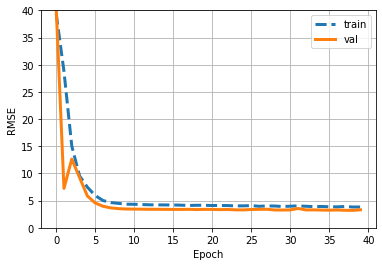

In [256]:
plot_RMSE(cnn_train_losses, cnn_valid_losses, y_max=40)

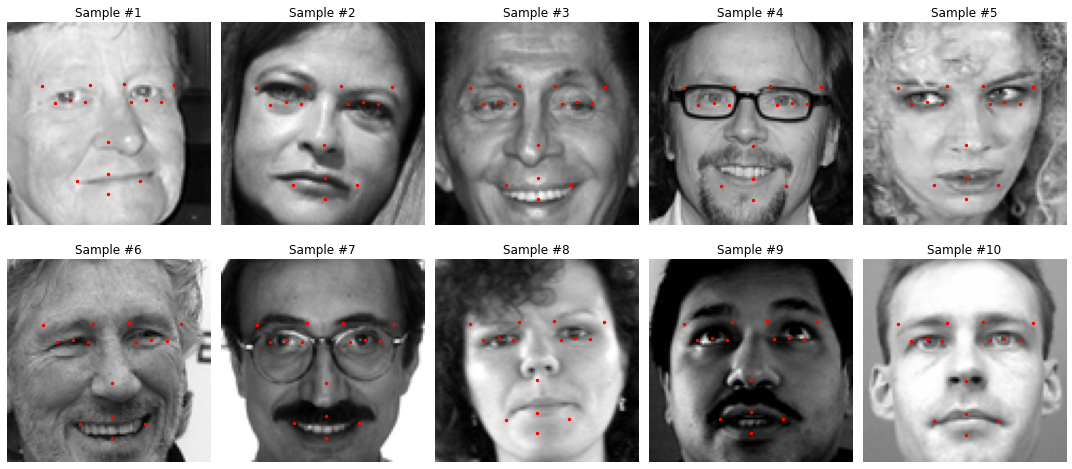

In [257]:
model.load_state_dict(torch.load('aug_cnn.pt'))
columns = train_df.drop('Image', axis=1).columns
predictions = predict(test_loader, model)
view_pred_df(columns, test_df, predictions)